# Predictions

## Data wrangling

In [1]:
# Preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
import lightgbm as lgb
import pyarrow.feather as feather
from os import chdir, getcwd

In [2]:
data_dir = '/home/jovyan/work/Data/'
results_dir = '/home/jovyan/work/Results/'

In [3]:
select_features = ['year',
                   'ln.Tot_IFF',
                   'dist', 'contig', 'comcol', 'col45', 'comlang_off', 'comleg_posttrans',
                   'gdp_o', 'gdp_d', 'pop_o', 'pop_d',
                   'entry_cost_o', 'entry_cost_d',
                   'rta', 'tariff',
                   'ka_o', 'ka_d', 'kai_o', 'kao_o', 'kai_d', 'kao_d',
                   'rSecrecyScore', 'pSecrecyScore',
                   'rCPI', 'pCPI',
                   'rCorrCont', 'pCorrCont',
                   'rRegQual', 'pRegQual', 
                   'rRuleLaw', 'pRuleLaw']
features = ['dist', 'contig', 'comcol', 'col45', 'comlang_off', 'comleg_posttrans',
            'gdp_o', 'gdp_d', 'pop_o', 'pop_d',
            'entry_cost_o', 'entry_cost_d',
            'rta', 'tariff',
            'ka_o', 'ka_d', 'kai_o', 'kao_o', 'kai_d', 'kao_d',
            'rSecrecyScore', 'pSecrecyScore',
            'rCPI', 'pCPI',
            'rCorrCont', 'pCorrCont',
            'rRegQual', 'pRegQual', 
            'rRuleLaw', 'pRuleLaw']

## Split into training and test samples

In [4]:
train_smp = feather.read_feather(results_dir + 'train_smp.feather')
test_smp = feather.read_feather(results_dir + 'test_smp.feather')

In [5]:
train_smp = train_smp[select_features]
test_smp = test_smp[select_features]

In [6]:
train_smp.dropna(axis=0, how='any', inplace=True)
test_smp.dropna(axis=0, how='any', inplace=True)

In [7]:
feather.write_feather(test_smp, results_dir + 'test_smp_trans.feather')

In [8]:
Y_train = train_smp[['ln.Tot_IFF']]
X_train = train_smp[features]
Y_test = test_smp[['ln.Tot_IFF']]
X_test = test_smp[features]
Y_val = Y_train.values
X_val = X_train.values

## Linear regression

In [9]:
linear_mod = LinearRegression()  
linear_mod.fit(X_val, Y_val)

LinearRegression()

In [10]:
print(linear_mod.intercept_)
print(linear_mod.coef_)

[16.26257313]
[[-1.17002780e-04  2.62274567e+00 -1.00012048e+00  4.17285903e-01
   2.22174082e-01  5.31360318e-01  2.03010060e-10  2.85245650e-10
   1.81116399e-06  3.43907388e-06 -5.14521572e-02 -3.60551419e-02
   7.43672175e-02  5.94965674e-02  9.36752978e-02  3.57915606e-02
  -1.67930387e+00  1.86665445e+00 -2.35517004e+00  2.42675321e+00
  -2.00463414e-02 -4.56039445e-02  5.02227601e-02  2.89230938e-02
  -2.47176466e-02 -1.13009572e-02  4.43590568e-02  5.31556693e-02
  -3.36375721e-02 -4.13317508e-02]]


In [11]:
import statsmodels.api as sm
Xconst = sm.add_constant(X_train)
est = sm.OLS(Y_train, Xconst)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             ln.Tot_IFF   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     144.3
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        07:22:44   Log-Likelihood:                -15851.
No. Observations:                6637   AIC:                         3.176e+04
Df Residuals:                    6608   BIC:                         3.196e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.2626      0.545  

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
y_pred = linear_mod.predict(X_test)

In [13]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

Mean Absolute Error: 2.036397230385591
Mean Squared Error: 7.369767931014205
Root Mean Squared Error: 2.714731649908367


## Light GBM

In [14]:
lgbtrain = lgb.Dataset(X_train, Y_train)
lgbvalid = lgb.Dataset(X_test, Y_test)

In [15]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 100,
    'max_depth': 10,
    'learning_rate' : 0.1,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}
lgb_clf = lgb.train(
    params,
    lgbtrain,
    500,
    valid_sets=[lgbtrain, lgbvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=50,
    verbose_eval=500
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[276]	train's rmse: 0.540953	valid's rmse: 1.48092


In [16]:
print("RMSE of the validation set:", np.sqrt(metrics.mean_squared_error(Y_test, lgb_clf.predict(X_test))))
print("R^2 of the validation set:", r2_score(Y_test, lgb_clf.predict(X_test)))

RMSE of the validation set: 1.480915105591873
R^2 of the validation set: 0.8050333771705789


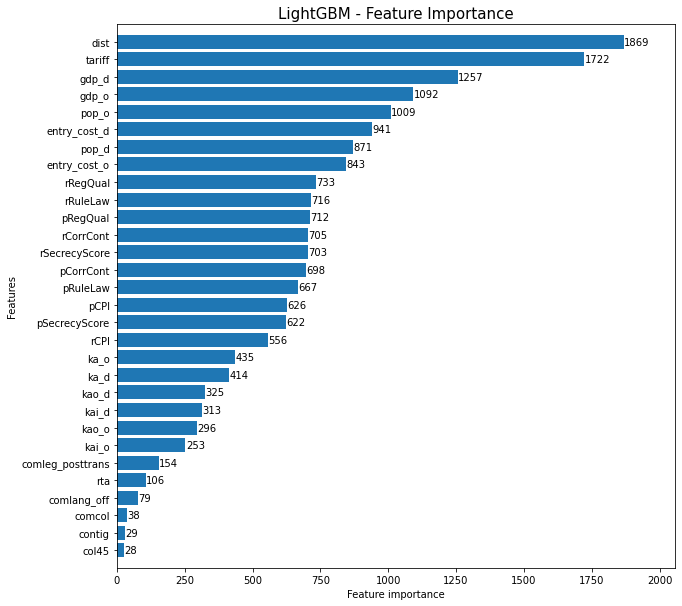

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
lgb.plot_importance(lgb_clf,height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [18]:
preds = pd.DataFrame(lgb_clf.predict(X_test))

In [19]:
feather.write_feather(preds, results_dir + 'preds.feather')